filtered data: https://jmcauley.ucsd.edu/data/googlelocal/kcore/

In [74]:
import gzip
from collections import defaultdict
import datetime
import dateutil
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random

In [2]:
path = 'C:/Users/david/Documents/GitHub/CSE-158---CA-Google-Local-Predictions/'

In [3]:
def parseData(fname):
    for l in gzip.open(fname):
        d = eval(l)
        yield d

In [4]:
#filtering out users with <5 interactions
data_CA5 = list(parseData(path+"CA_5.json.gz"))

In [5]:
data_CA5[0]

{'rating': 4.0,
 'reviewerName': 'Mary Gainza',
 'reviewText': 'Gap always has a jean that fits awesomely, i wish their prices were a bit competitive in comparison to their outlets, also the amount of the pieces they have in store sometimes fly so quick that is hard to find an specific size with their best sellers, but in general i really like this store and most of their products.',
 'categories': ['Clothing Store',
  "Women's Clothing Store",
  "Children's Clothing Store"],
 'gPlusPlaceId': '100556368174926958612',
 'unixReviewTime': 1355436757,
 'reviewTime': 'Dec 13, 2012',
 'gPlusUserId': '100000715097692381911'}

In [6]:
# filtering out users with <10 interactions, subset of CA_5
# only users with 10 or more interactions
data_CA10 = list(parseData(path+'CA_10.json.gz'))

In [7]:
data_CA10[0]

{'rating': 4.0,
 'reviewerName': 'Rick Casady',
 'reviewText': None,
 'categories': ['Sushi Restaurant', 'Asian Restaurant', 'Japanese Restaurant'],
 'gPlusPlaceId': '100539657974695665920',
 'unixReviewTime': 1302881457,
 'reviewTime': 'Apr 15, 2011',
 'gPlusUserId': '100003840837471130074'}

In [8]:
places_CA = list(parseData(path+'places_CA.json.gz'))

In [9]:
#reviews_CA = list(parseData(path+'reviews_CA.json.gz'))

In [10]:
print(len(data_CA5),len(data_CA10),len(places_CA))

163408 76967 171271


In [11]:
places_CA[0]

{'name': 'Diamond Valley Lake Marina',
 'price': None,
 'address': ['2615 Angler Ave', 'Hemet, CA 92545'],
 'hours': [['Monday', [['6:30 am--4:15 pm']]],
  ['Tuesday', [['6:30 am--4:15 pm']]],
  ['Wednesday', [['6:30 am--4:15 pm']], 1],
  ['Thursday', [['6:30 am--4:15 pm']]],
  ['Friday', [['6:30 am--4:15 pm']]],
  ['Saturday', [['6:30 am--4:15 pm']]],
  ['Sunday', [['6:30 am--4:15 pm']]]],
 'phone': '(951) 926-7201',
 'closed': False,
 'gPlusPlaceId': '104699454385822125632',
 'gps': [33.703804, -117.003209]}

In [12]:
count = set()
count1 = 0
count2 = 0
count3 = 0
count4 = 0
count5 = 0
for i in places_CA:
    count.add(i['price'])
    if i['price'] == '':
        count1 +=1
    if i['price'] == None:
        count2 +=1
    if i['price'] == '$':
        count3 +=1
    if i['price'] == '$$':
        count4 +=1
    if i['price'] == '$$$':
        count5 +=1
count

{'', '$', '$$', '$$$', None}

In [13]:
[count1,count2,count3,count4,count5]

[197, 124356, 2068, 23954, 20696]

**EDA**<br />
1) distribution of reviews across time of day (David): **more or less done as of (11/25)**<br />
2) categories for businesses (Andrew)<br />
3) distribution across years/months (David): **more or less done as of (11/25)**<br />
4) distribution of words in review (Andrew)<br />
5) what categories there are (Maricela)
6) top 10 words (Maricela)

EDA #1: Distributions of Ratings by time of day (David)

In [14]:
count = 0
lst = set()
for d in data_CA5:
    if type(d['unixReviewTime']) != int:
        count +=1
        lst.add(d['unixReviewTime'])
print(count,lst)

# might need to remove missing datetimes for the entire analysis: 
# 13,249 missing datetimes in data_CA5
# 5,280 missing datetimes in data_CA10
ratingsTime_5 = []
for d in data_CA5:
    if d['unixReviewTime'] != None:
        t = datetime.datetime.fromtimestamp(d['unixReviewTime'])
        ratingsTime_5.append((t,d['rating']))
ratingsTime_5.sort()
len(ratingsTime_5)

13249 {None}


150159

In [15]:
ratingsTimesOfDay = []
for t,r in ratingsTime_5:
    ratingsTimesOfDay.append((t.hour,t.minute,r))
ratingsTimesOfDay.sort()

In [16]:
tenMinInts = defaultdict(list)
fifteenMinInts = defaultdict(list)
hourlyInts = defaultdict(list)
hour = 0
for h,m,r in ratingsTimesOfDay:
    if h == hour:
        for minute in [10,20,30,40,50,60]:
            if m in [i for i in range(0+minute-10,minute)]:
                tenMinInts[h,minute-10].append(r)
        for minute in [15,30,45,60]:
            if m in [i for i in range(0+minute-15,minute)]:
                fifteenMinInts[h,minute-15].append(r)
        hourlyInts[h].append(r)
    hour = h
tenMinIntKeys = [h*60+m for h,m in list(tenMinInts.keys())]
fifteenMinIntKeys = [h*60+m for h,m in list(fifteenMinInts.keys())]
hourlyIntKeys = [h for h in list(hourlyInts.keys())]
#print(tenMinIntKeys)
tenMinAvgs = []
fifteenMinAvgs = []
hourlyAvgs = []
for key in tenMinInts:
    tenMinAvgs.append(np.mean(tenMinInts[key]))
for key in fifteenMinInts:
    fifteenMinAvgs.append(np.mean(fifteenMinInts[key]))
for key in hourlyInts:
    hourlyAvgs.append(np.mean(hourlyInts[key]))
print('10 min ints: ',min(tenMinAvgs),max(tenMinAvgs))
print('15 min ints: ',min(fifteenMinAvgs),max(fifteenMinAvgs))
print('hourly ints: ',min(hourlyAvgs),max(hourlyAvgs))
#print(tenMinAvgs)

10 min ints:  3.7801047120418847 4.328571428571428
15 min ints:  3.8151260504201683 4.209756097560976
hourly ints:  3.911318553092182 4.167906662157592


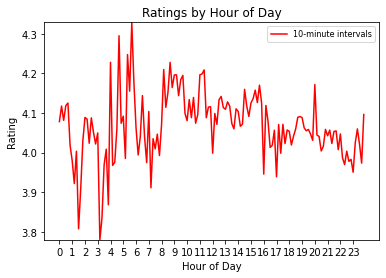

In [17]:
plt.plot(tenMinIntKeys,tenMinAvgs,label='10-minute intervals',color='red')
plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(tenMinAvgs),max(tenMinAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

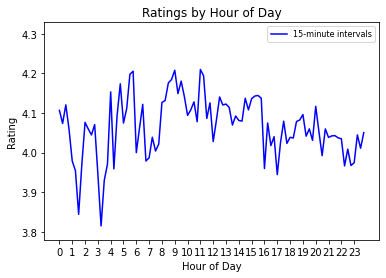

In [18]:
plt.plot(fifteenMinIntKeys,fifteenMinAvgs,label='15-minute intervals',color='blue')
plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(tenMinAvgs),max(tenMinAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

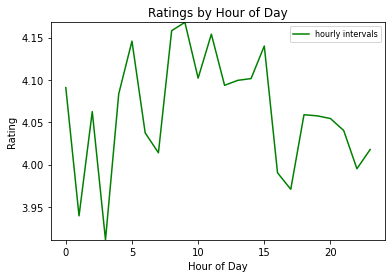

In [19]:
plt.plot(hourlyIntKeys,hourlyAvgs,label='hourly intervals',color='green')
#plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(hourlyAvgs),max(hourlyAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

EDA #3: Distribution of Ratings across years/months (David)

In [20]:
# might need to remove missing datetimes for the entire analysis: 
# 13,249 missing datetimes in data_CA5
# 5,280 missing datetimes in data_CA10

# using the same ratingsTime_5 list as Distribution of Ratings for time of day EDA

In [21]:
wSize = 4000
x = [r[0] for r in ratingsTime_5] # as raw times
y = [r[1] for r in ratingsTime_5] # ratings
xu = [time.mktime(d.timetuple()) for d in x] # as unix times

In [22]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [23]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [24]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

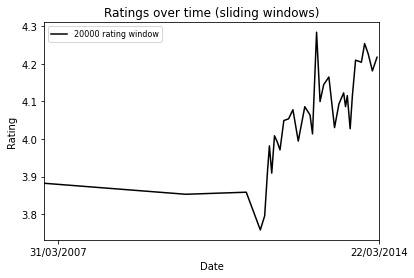

In [25]:
#remove outlier?
plt.plot(X[::4000],Y[::4000], label="20000 rating window", color='k')
plt.xticks([X[100], X[-350]], [x[wSize+100].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()

**Baseline Model**: Predict the average every time and compute MSE [with and without rounding] (Andrew)<br /> 
**Ablation Experiment**: to determine feature importance<br />
    or Principal Component Analysis<br />
Look at Prof's paper from this dataset

Random Ideas:
1) Naive Bayes?

In [26]:
X=[]
y=[]
for rowDict in data_CA5:
    data = []
    for key in rowDict:
        if key == 'rating':
            y.append(rowDict[key])
        else:
            data.append(rowDict[key])
    X.append(data)

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.35)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=(15/35))
print(len(X_train),len(X_val),len(X_test))

106215 32681 24512


**Location Based Social Networks?**<br />
(David)

In [28]:
data_CA5[0]

{'rating': 4.0,
 'reviewerName': 'Mary Gainza',
 'reviewText': 'Gap always has a jean that fits awesomely, i wish their prices were a bit competitive in comparison to their outlets, also the amount of the pieces they have in store sometimes fly so quick that is hard to find an specific size with their best sellers, but in general i really like this store and most of their products.',
 'categories': ['Clothing Store',
  "Women's Clothing Store",
  "Children's Clothing Store"],
 'gPlusPlaceId': '100556368174926958612',
 'unixReviewTime': 1355436757,
 'reviewTime': 'Dec 13, 2012',
 'gPlusUserId': '100000715097692381911'}

**Temporal Dynamics**<br />
(David)<br />
Tensorflow FPMC model

In [29]:
interactions=[]
interactionsPerUser=defaultdict(list)
userIDs={}
itemIDs={}
for d in data_CA5:
    user = d['gPlusUserId']
    if user == None: continue
    business = d['gPlusPlaceId']
    if business == None: continue
    time = d['unixReviewTime']
    if time == None: continue
    rating = d['rating']
    if not user in userIDs: userIDs[user] = len(userIDs)
    if not business in itemIDs: itemIDs[business] = len(itemIDs)
    interactionsPerUser[user].append([time,business,rating])
    interactions.append((time,user,business,rating))

In [30]:
interactionsWithPrevious = []
for user in interactionsPerUser:
    interactionsPerUser[user].sort()
    lastItem = 'dummy'
    for t,i,r in interactionsPerUser[user]:
        interactionsWithPrevious.append([t,user,i,lastItem,r])
        lastItem=i

In [ ]:
interactionsWithPrevious

In [32]:
itemsPerUser = defaultdict(set)
for _,u,i,_ in interactions:
    itemsPerUser[u].add(i)

In [33]:
items = list(itemIDs.keys())
itemIDs['dummy'] = len(itemIDs)

In [34]:
class FPMC(tf.keras.Model):
    def __init__(self, K, lamb, UI = 1, IJ = 1):
        super(FPMC, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaUI = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaIU = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaIJ = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaJI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb
        # Which terms to include
        self.UI = UI
        self.IJ = IJ

    # Prediction for a single instance
    def predict(self, u, i, j):
        p = self.betaI[i] + self.UI * tf.tensordot(self.gammaUI[u], self.gammaIU[i], 1) +\
                            self.IJ * tf.tensordot(self.gammaIJ[i], self.gammaJI[j], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaUI) +\
                            tf.nn.l2_loss(self.gammaIU) +\
                            tf.nn.l2_loss(self.gammaIJ) +\
                            tf.nn.l2_loss(self.gammaJI))

    def call(self, sampleU, # user
                   sampleI, # item
                   sampleJ, # previous item
                   sampleK): # negative item
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        k = tf.convert_to_tensor(sampleK, dtype=tf.int32)
        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        x_uij = beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
        gamma_uk = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_ku = tf.nn.embedding_lookup(self.gammaIU, k)
        gamma_kj = tf.nn.embedding_lookup(self.gammaIJ, k)
        gamma_jk = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_k = tf.nn.embedding_lookup(self.betaI, k)
        x_ukj = beta_k + self.UI * tf.reduce_sum(tf.multiply(gamma_uk, gamma_ku), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_kj, gamma_jk), 1)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_uij - x_ukj)))

In [35]:
def trainingStep(model, interactions):
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ, sampleK = [], [], [], []
        for _ in range(100000):
            _,u,i,j,_ = random.choice(interactions) # positive sample from training set only
            k = random.choice(items) # negative sample from training set only
            while k in itemsPerUser[u]:
                k = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])
            sampleK.append(itemIDs[k])

        loss = model(sampleU,sampleI,sampleJ,sampleK)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [36]:
optimizer = tf.keras.optimizers.Adam(0.1)
modelFPMC = FPMC(5, 0.001, 1, 1)

In [47]:
data_CA5[0].keys()

dict_keys(['rating', 'reviewerName', 'reviewText', 'categories', 'gPlusPlaceId', 'unixReviewTime', 'reviewTime', 'gPlusUserId'])

In [60]:
X_trainFPMC = [d for d in X_train if d[4] != None]
X_testFPMC = [d for d in X_test if d[4] != None]

In [61]:
X_trainFPMC = []
y_trainFPMC = []
for i in range(len(X_train)):
    d = X_train[i]
    r = y_train[i]
    if d[4] != None: 
        X_trainFPMC.append(d)
        y_trainFPMC.append(r)
        
X_testFPMC = []
y_testFPMC = []
for i in range(len(X_test)):
    d = X_test[i]
    r = y_test[i]
    if d[4] != None: 
        X_testFPMC.append(d)
        y_testFPMC.append(r)

In [62]:
trainFPMC = defaultdict(list)
testFPMC = defaultdict(list)
for i in range(len(X_trainFPMC)):
    d = X_trainFPMC[i]
    trainFPMC[d[6]].append([d[4],d[3],y_trainFPMC[i]]) #time,business,rating
for i in range(len(X_testFPMC)):
    d = X_testFPMC[i]
    testFPMC[d[6]].append([d[4],d[3],y_testFPMC[i]])

In [ ]:
trainFPMC

In [64]:
interactionsWithPreviousTrain = []

for user in trainFPMC:
    trainFPMC[user].sort()
    lastItem = 'dummy'
    for t,i,r in trainFPMC[user]:
        interactionsWithPreviousTrain.append([t,user,i,lastItem,r])
        lastItem = i

In [68]:
testFPMC['104328546195224662053']

[[1375643251, '101023289237172670891', 3.0],
 [1375547958, '118349490009053403221', 5.0]]

In [69]:
interactionsPrevTest = []
for user in testFPMC:
    testFPMC[user].sort()
    lastItem = 'dummy'
    for t,i,r in testFPMC[user]:
        interactionsWithPreviousTrain.append([t,user,i,lastItem,r])
        interactionsPrevTest.append([t,user,i,lastItem,r])
        lastItem = i

In [70]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for _,u,i,j,_ in interactionsPrevTest:
    interactionsTestPerUser[u].add((i,j))
    itemSet.add(i)
    itemSet.add(j)

In [71]:
def AUCu(model, u, N):
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
    positive = random.sample(interactionsTestPerUser[u],N)
    negative = random.sample(itemSet,N)
    for (i,j),k in zip(positive,negative):
        sp = model.predict(userIDs[u], itemIDs[i], itemIDs[j]).numpy()
        sn = model.predict(userIDs[u], itemIDs[k], itemIDs[j]).numpy()
        if sp > sn:
            win += 1
    return win/N

In [72]:
def AUC(model):
    av = []
    for u in interactionsTestPerUser:
        av.append(AUCu(model, u, 10))
    return sum(av) / len(av)

In [75]:
for i in range(100):
    obj = trainingStep(modelFPMC, interactionsWithPreviousTrain)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.70878035
iteration 20, objective = 0.69434625
iteration 30, objective = 0.6805675
iteration 40, objective = 0.67944545
iteration 50, objective = 0.6788653
iteration 60, objective = 0.67791444
iteration 70, objective = 0.67817193
iteration 80, objective = 0.6781862
iteration 90, objective = 0.6784634
iteration 100, objective = 0.6780923


In [76]:
print(" AUC = " + str(AUC(modelFPMC)))

 AUC = 0.6484748982622613


**Price?**<br />
(Andrew)<br />
One-Hot Encoding

**Text Analysis?**<br />
(Maricela)<br />
TfIdf?

**Cosine Feature**<br />
(Andrew)

In [37]:
#Train-Validation-Validation (65%-20%-15%)
#compare MSE, look into F1?, or other model measurements

Linear Regression Model<br />
Decision Tree Regression/Classification<br />
SVD<br />
K-Nearest Neighbors<br />
Other Models?

Evaluating Overfitting<br />
test on both CA_5 and CA_10